In [2]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import math
from sklearn.model_selection import train_test_split
from functools import reduce
from functools import partial
import operator
from timeit import default_timer
from matplotlib.ticker import FormatStrFormatter
import deepxde as dde
import time

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.
/home/luke/miniconda3/lib/python3.12/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403380481/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


In [3]:
def set_size(width, fraction=1, subplots=(1, 1), height_add=0):
    """Set figure dimensions to avoid scaling in LaTeX.

    Parameters
    ----------
    width: float or string
            Document width in points, or string of predined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = height_add + fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return (fig_width_in, fig_height_in)

tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "times",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/bel fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}

plt.rcParams.update(tex_fonts)

In [123]:
def solvePDEAdaptive(I, a, L, dt,F, T, lam, solveControl, kernelEstimator, gamma, lamGuess, debug):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]
    lArr = []
    kArr = []
    lHat = lamGuess
    lArr.append(lHat)

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]
    s= 0
    for i in range(1, Nt):
        kEst = kernelEstimator(lHat, dx)
        if i % int(Nt/100) == 0 and debug==True:
            print("i", i, "/", nt)
            print("wTerm", wTerm)
            print("uTerm", uTerm)
            print("lhatdelta", lHatDelta)
            print(time.time() - s)
            s = time.time()
            kArr.append(kEst)
            
        # Compute u at inner mesh points
        u[i][1:Nx] = u[i-1][1:Nx] +  \
                      F*(u[i-1][0:Nx-1] - 2*u[i-1][1:Nx] + u[i-1][2:Nx+1]) + dt*lam[1:Nx]*u[i-1][1:Nx]

        lHatDelta,wTerm, uTerm = estimateLambdaHatDelta(x, u[i-1], kEst, dx, gamma)
        lHat = lHat + dt*lHatDelta
        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kEst, Nx-1, dx)
        lArr.append(lHat)
    return u, x, lArr, kArr

def solvePDE(I, a, L, dt,F, T, lam, solveControl, kernel):
    # Code adapted from: https://hplgit.github.io/fdm-book/doc/pub/book/pdf/fdm-book-4print.pdf
    Nt = int(round(T/float(dt)))
    t = np.linspace(0, Nt*dt, Nt)  
    dx = np.sqrt(a*dt/F)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)      
    # Make sure dx and dt are compatible with x and t
    dx = x[1] - x[0]
    dt = t[1] - t[0]

    u = np.zeros((Nt, Nx+1))

    # Set initial condition u(x,0) = I(x)
    for i in range(0, Nx+1):
        u[0][i] = I[i]

    for i in range(1, Nt):
        if i % int(Nt/10) == 0:
            print("i", i, "/", nt)
        # Compute u at inner mesh points
        u[i][1:Nx] = u[i-1][1:Nx] +  \
                      F*(u[i-1][0:Nx-1] - 2*u[i-1][1:Nx] + u[i-1][2:Nx+1]) + dt*lam[1:Nx]*u[i-1][1:Nx]

        # Insert boundary conditions
        u[i][0] = 0;  u[i][Nx] = solveControl(u[i], kernel, Nx-1, dx)
    return u

def solveKernelFunction(lam, dx):
    k = np.zeros((len(lam), len(lam)))
    # First we calculate a at each timestep
    a = lam

    # FD LOOP
    k[1][1] = -(a[1] + a[0]) * dx / 4
    for i in range(1, len(lam)-1):
        k[i+1][0] = 0
        k[i+1][i+1] = k[i][i]-dx/4.0*(a[i-1] + a[i])
        k[i+1][i] = k[i][i] - dx/2 * a[i]
        for j in range(1, i):
                k[i+1][j] = -k[i-1][j] + k[i][j+1] + k[i][j-1] + a[j]*(dx**2)*(k[i][j+1]+k[i][j-1])/2
    return k

def solveLambdaFunction(x, gamma):
    lam = np.zeros(nx)
    for idx, val in enumerate(x):
        lam[idx] = 5
    return lam

def solveControl(u, kernel, nx, dx):
    return sum(kernel[-1][0:nx+1]*u[0:nx+1])*dx


def openLoop(u, kernel, nx, dx):
    return 0

def zeroToNan(x):
    for i in range(len(x)):
        for j in range(len(x[0])):
            if j >= i:
                x[i][j] = float('nan')
    return x

# PDE L2 Error
def getPDEl2(u, uhat):
    pdeError = np.zeros(nt-1)
    for i in range(1, nt):
        error = 0
        for j in range(nx):
            error += (u[i][j] - uhat[i][j])**2
        error = np.sqrt(error*0.01)
        pdeError[i-1] = error
    return pdeError

def solveW(u, kernel, dx):
    w = np.zeros(len(kernel))
    for i in range(0, len(kernel)):
        w[i] = u[i]-sum(kernel[i][0:i]*u[0:i])*dx
    return w

def solveWIntegral(x, w, dx):
    return sum(w[0:]**2)*dx

def estimateLambdaHatDelta(x, u, k, dx, gamma):
    w = solveW(u, k, dx)
    wInt = solveWIntegral(x, w, dx)
    lambdaHat = np.zeros(len(w))
    kt= k.transpose()
    for i in range(0, len(w)):
        middleTerm = (w[i] - sum(kt[i][i:]*w[i:])*dx)*u[i]
        lambdaHat[i] = gamma/(1+wInt)*middleTerm 
    return lambdaHat, wInt, middleTerm

In [138]:
X = 1
dx = 0.01
nx = int(round(X/dx))
spatial = np.linspace(0, X, nx+1, dtype=np.float32)


T = .5
dt = 0.00001
nt = int(round(T/dt))
temporal = np.linspace(0, T, nt, dtype=np.float32)

In [235]:
init_cond = np.zeros(nx+1)
lam = np.zeros(nx+1)
lamGuess = np.zeros(nx+1)
for j in range(nx+1):
    init_cond[j] = 20
    lam[j] = 25*math.cos(9*math.acos(spatial[j])) +25
    lamGuess[j] = 25
    
u, s2, lArr, kArr= solvePDEAdaptive(init_cond, 1, 1, dt, dt/dx**2, T, lam, solveControl, solveKernelFunction, 50, lamGuess, True)

i 500 / 50000
wTerm 14497.131262212219
uTerm -7.905197889855364
lhatdelta [ 0.00000000e+00  3.56344149e-01  1.41838148e+00  3.16549638e+00
  5.56247896e+00  8.56299629e+00  1.21065675e+01  1.61277733e+01
  2.05483174e+01  2.52936544e+01  3.02774936e+01  3.54269540e+01
  4.06574180e+01  4.59068802e+01  5.10998417e+01  5.61911977e+01
  6.11187097e+01  6.58565306e+01  7.03565313e+01  7.46113333e+01
  7.85852969e+01  8.22866943e+01  8.56894526e+01  8.88138688e+01
  9.16402867e+01  9.41975517e+01  9.64697601e+01  9.84915108e+01
  1.00248766e+02  1.01779894e+02  1.03071575e+02  1.04164647e+02
  1.05045881e+02  1.05757727e+02  1.06286699e+02  1.06676222e+02
  1.06912292e+02  1.07038748e+02  1.07040782e+02  1.06962097e+02
  1.06786742e+02  1.06557741e+02  1.06257617e+02  1.05928200e+02
  1.05550095e+02  1.05163481e+02  1.04746662e+02  1.04337782e+02
  1.03912499e+02  1.03506609e+02  1.03092808e+02  1.02704293e+02
  1.02310498e+02  1.01941800e+02  1.01564063e+02  1.01204598e+02
  1.00825329e+02

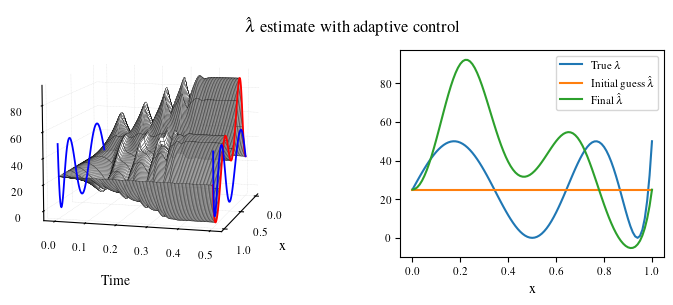

In [140]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1, 2), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=2, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.15, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
lArr=  np.array(lArr)

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, lArr, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time", labelpad=10)
axes.set_zlabel(r"$\hat{\lambda}(x, t)$")
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
vals = lArr[-1]
test = np.ones(len(lam))*temporal[-1]

axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes.plot(spatial, test, lam, color="blue", lw=1.3, antialiased=True)
axes.plot(spatial, np.zeros(len(lam)), lam, color="blue", lw=1.3, antialiased=True)


subfig = subfigs[1]
# subfig.suptitle(r"Comparison of initial and final $\hat{\beta}$ for $\sigma=2.9, 3.1$")

subfig.subplots_adjust(left=0.15, bottom=0.2, right=0.97, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=1)
axes.plot(spatial, lam, label=r"True $\lambda$")
axes.plot(spatial, lamGuess, label=r"Initial guess $\hat{\lambda}$")
axes.plot(spatial, lArr[-1], label=r"Final  $\hat{\lambda}$")
axes.legend()
axes.set_xlabel("x")

subfig.suptitle(r"$\hat{\lambda}$ estimate with adaptive control", x=0, y=0.96, ha="center")
plt.savefig("lambdaComparisonTight.pdf", dpi=300)

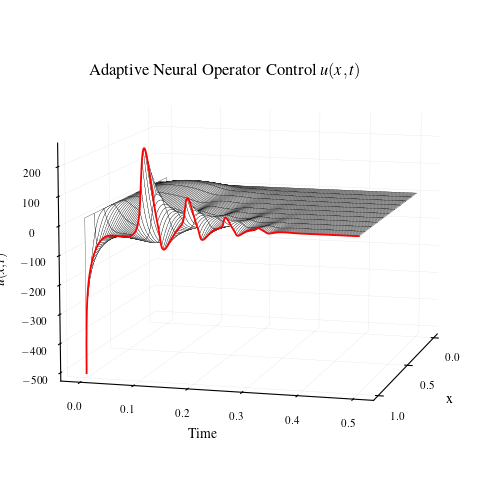

In [141]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1,1), height_add=0))

subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

subfig = subfigs
subfig.subplots_adjust(left=0.07, bottom=0, right=1, top=1.1)
subfig.suptitle(r"Adaptive Neural Operator Control $u(x, t)$")
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, u, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
test = np.ones(nt)
vals = (u.transpose())[-1] 
axes.plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time")
axes.set_zlabel(r"$u(x, t)$", rotation=90)
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

plt.savefig("adaptiveControlParabolicBig.pdf", dpi=300)

In [ ]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (1, 2), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=2, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.15, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
lArr=  np.array(lArr)

for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, lArr, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time", labelpad=10)
axes.set_zlabel(r"$\hat{\lambda}(x, t)$")
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
vals = lArr[-1]
test = np.ones(len(lam))*temporal[-1]

axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes.plot(spatial, test, lam, color="blue", lw=1.3, antialiased=True)
axes.plot(spatial, np.zeros(len(lam)), lam, color="blue", lw=1.3, antialiased=True)


subfig = subfigs[1]
# subfig.suptitle(r"Comparison of initial and final $\hat{\beta}$ for $\sigma=2.9, 3.1$")

subfig.subplots_adjust(left=0.15, bottom=0.2, right=0.97, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=1)
axes.plot(spatial, lam, label=r"True $\lambda$")
axes.plot(spatial, lamGuess, label=r"Initial guess $\hat{\lambda}$")
axes.plot(spatial, lArr[-1], label=r"Final  $\hat{\lambda}$")
axes.legend()
axes.set_xlabel("x")

subfig.suptitle(r"$\hat{\lambda}$ estimate with adaptive control", x=0, y=0.96, ha="center")
plt.savefig("lambdaComparisonTight.pdf", dpi=300)

In [ ]:
res = 1
fig = plt.figure(figsize=set_size(516, 0.99, (2, 3), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=2, hspace=0)
subfig = subfigs[0]
subfig.subplots_adjust(left=0.15, bottom=0, right=1, top=1.1)
axes = subfig.subplots(nrows=1, ncols=3, subplot_kw={"projection": "3d", "computed_zorder": False})
lArr=  np.array(lArr)

for ax in axes:
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1, 1, 1))
    
meshx, mesht = np.meshgrid(spatial, temporal)
                     
axes.plot_surface(meshx, mesht, lArr, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                        alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
axes.view_init(10, 15)
axes.set_xlabel("x")
axes.set_ylabel("Time", labelpad=10)
axes.set_zlabel(r"$\hat{\lambda}(x, t)$")
axes.zaxis.set_rotate_label(False)
axes.set_xticks([0, 0.5, 1])
#axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
vals = lArr[-1]
test = np.ones(len(lam))*temporal[-1]

axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
axes.plot(spatial, test, lTrue, color="blue", lw=1.3, antialiased=True)


subfig = subfigs[1]
# subfig.suptitle(r"Comparison of initial and final $\hat{\beta}$ for $\sigma=2.9, 3.1$")

subfig.subplots_adjust(left=0.15, bottom=0.2, right=0.97, top=0.85, wspace=0.3, hspace=0.1)
axes = subfig.subplots(nrows=1, ncols=1)
axes.plot(spatial, lam, label=r"True $\lambda$")
axes.plot(spatial, np.ones(len(lam)), label=r"Initial guess $\hat{\lambda}$")
axes.plot(spatial, lArr[-1], label=r"Final  $\hat{\lambda}$")
axes.legend()
axes.set_xlabel("x")


subfig.suptitle(r"$\hat{\lambda}$ estimate with adaptive control", x=0, y=0.96, ha="center")
plt.savefig("lambdaComparisonTight.pdf", dpi=300)

In [255]:
# Build animations
def savefig(l,truel, u,count, lArr, uArr, val):
    res = 1
    fig = plt.figure(figsize=set_size(516, 0.99, (2, 2), height_add=1))
    subfigs = fig.subfigures(nrows=2, ncols=2, hspace=0, wspace=0)

    # PLOT L REGULAR
    subfig = subfigs[1][0]
    axes = subfig.subplots(nrows=1, ncols=1)
    axes.plot(np.linspace(0, 1, len(l)), l, label="$\hat{\lambda}$")
    axes.plot(np.linspace(0, 1, len(truel)), truel, label="$\lambda$")
    axes.set_xlabel("x", labelpad=-3, zorder=1)
    axes.set_yticks([-25, 0, 25, 50, 75, 100])
    axes.legend()
    subfig.suptitle(r"$\hat{\lambda}$" + " at $t=${0:.3f}".format(dt*val))

    # PLOT U REGULAR 
    subfig = subfigs[1][1]
    axes = subfig.subplots(nrows=1, ncols=1)
    axes.plot(np.linspace(0, 1, len(u)), u)
    axes.set_xlabel("x", labelpad=-3, zorder=1)
    axes.set_yticks([-500, -250, 0, 250, 500])
    axes.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    subfig.suptitle("$u$ at $t=${0:.3f}".format(dt*val))

    # PLOT L 3D 
    subfig = subfigs[0][0]
    subfig.subplots_adjust(left=0.0, bottom=0, right=1, top=1.1)
    axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
    lArr=  np.array(lArr)
    
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1, 1, 1))
        
    meshx, mesht = np.meshgrid(spatial, temporal)
    plotVals = lArr
    plotVals[val:] = np.nan
                         
    axes.plot_surface(meshx, mesht, plotVals, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                            alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    # axes.set_ylim(0, val*dt)
    axes.view_init(10, 15)
    axes.set_xlabel("x")
    axes.set_ylabel("Time", labelpad=5)

    axes.zaxis.set_rotate_label(False)


    vals = lArr[val-1]
    test = np.ones(len(lam))*(val*dt)
    
    axes.plot(spatial, test, vals, color="red", lw=1.3, antialiased=True)
    axes.plot(spatial, np.zeros(len(test)), truel, color="blue", lw=1.3, antialiased=True)
    # axes.plot(spatial[0:count], np.zeros(len(lam)), lam, color="blue", lw=1.3, antialiased=True)
    subfig.suptitle("$\hat{\lambda}$ Estimate")
    axes.set_xticks([0, 0.5, 1])
    axes.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    axes.set_zticks([-25, 0, 25, 50, 75, 100])


    # ################
    # U PLOT 3D
    subfig = subfigs[0][1]
    subfig.suptitle("u(x, t)")

    subfig.subplots_adjust(left=0.0, bottom=0, right=1, top=1.1)
    axes = subfig.subplots(nrows=1, ncols=1, subplot_kw={"projection": "3d", "computed_zorder": False})
    
    for axis in [axes.xaxis, axes.yaxis, axes.zaxis]:
        axis._axinfo['axisline']['linewidth'] = 1
        axis._axinfo['axisline']['color'] = "b"
        axis._axinfo['grid']['linewidth'] = 0.2
        axis._axinfo['grid']['linestyle'] = "--"
        axis._axinfo['grid']['color'] = "#d1d1d1"
        axis.set_pane_color((1, 1, 1))
        
    meshx, mesht = np.meshgrid(spatial, temporal)
    plotVals = uArr.copy()
    plotVals[val:] = np.nan
                         
    axes.plot_surface(meshx, mesht, plotVals, edgecolor="black",lw=0.2, rstride=250, cstride=10, 
                            alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    # axes.set_ylim(0, val*dt)
    axes.view_init(10, 15)
    axes.set_xlabel("x")
    axes.set_ylabel("Time", labelpad=5)

    axes.zaxis.set_rotate_label(False)
    #axes.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
  
    test = np.ones(nt)
    values = (uArr.transpose())[-1] 
    values[val:] = np.nan
    axes.plot(test[1:], temporal[1:], values[1:], color="red", lw=1.3, antialiased=True)
    axes.set_xticks([0, 0.5, 1])
    axes.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5])
    axes.set_zticks([-500, -250, 0, 250, 500])

    
    stringVal = "animation/img" +str( count).zfill(3) + ".png"
    plt.savefig(stringVal, dpi=300)
    plt.close()
for i in range(0, len(lArr), 500):
    v1 = u[i].copy()
    v2 = u.copy()
    savefig(lArr[i], lam, v1, int(i/500), lArr, v2, i)

<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:60: SyntaxWarning: invalid escape sequence '\h'
<>:10: SyntaxWarning: invalid escape sequence '\h'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:60: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_1251518/1686715647.py:10: SyntaxWarning: invalid escape sequence '\h'
  axes.plot(np.linspace(0, 1, len(l)), l, label="$\hat{\lambda}$")
/tmp/ipykernel_1251518/1686715647.py:11: SyntaxWarning: invalid escape sequence '\l'
  axes.plot(np.linspace(0, 1, len(truel)), truel, label="$\lambda$")
/tmp/ipykernel_1251518/1686715647.py:60: SyntaxWarning: invalid escape sequence '\h'
  subfig.suptitle("$\hat{\lambda}$ Estimate")


In [120]:
init_cond = np.zeros(nx+1)
lam = np.zeros(nx+1)
lamGuess = np.zeros(nx+1)
for j in range(nx+1):
    init_cond[j] = 10
    lam[j] =25*math.cos(9*math.acos(spatial[j])) +25
    lamGuess[j] = 25
k = solveKernelFunction(lam, dx)
    
uopen = solvePDE(init_cond, 1, 1, dt, dt/dx**2, T, lam, openLoop, k)
print(uopen[-1])

i 6000 / 60000
i 12000 / 60000
i 18000 / 60000
i 24000 / 60000
i 30000 / 60000
i 36000 / 60000
i 42000 / 60000
i 48000 / 60000
i 54000 / 60000
[     0.           7100.15456564  14191.95956107  21263.91174694
  28301.45459267  35287.14375706  42200.87816926  49020.19556195
  55720.62945656  62276.12269937  68659.49063383  74842.9251687
  80798.52917881  86498.86927138  91917.53377959  97029.68213033
 101812.57151255 106246.04701241 110312.98217267 113999.65827911
 117296.07236869 120196.16616394 122697.97052987 124803.66280053
 126519.53692062 127855.88912535 128826.82448206 129449.99162053
 129746.25530174 129739.31731677 129455.29800598 128922.29057041
 128169.90024812 127228.78071198 126130.17841556 124905.49431379
 123585.87166906 122201.81612116 120782.85237757 119357.22083009
 117951.61473238 116590.95743925 115298.21728855 114094.25723483
 112997.71468881 112024.90646111 111189.75386078 110503.72239507
 109975.77089984 109612.3057786  109417.13646546 109391.42942943
 109533.65938

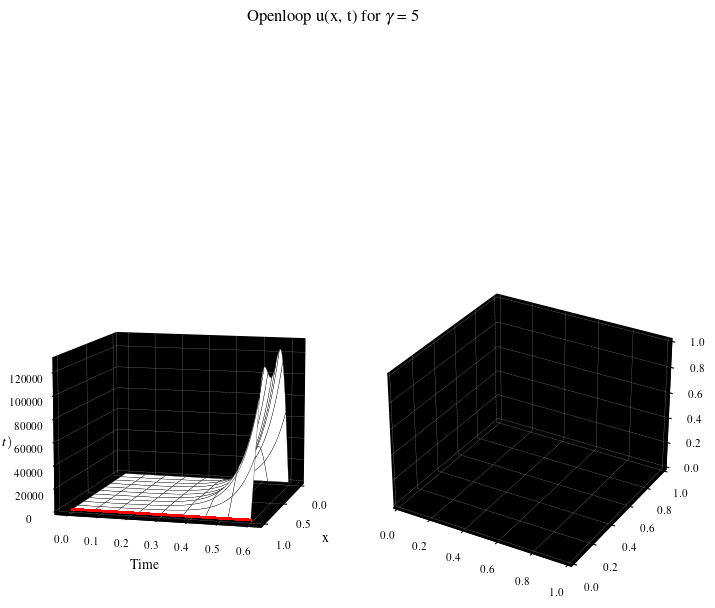

In [121]:
res = 10
fig = plt.figure(figsize=set_size(516, 0.99, (2, 1), height_add=1))
subfigs = fig.subfigures(nrows=1, ncols=1, hspace=0)

#### OPEN LOOP PLOT ####
subfig = subfigs
subfig.subplots_adjust(left=0.06, bottom=0, right=1, top=1.1, wspace=0.1, hspace=0)

subfig.suptitle(r"Openloop u(x, t) for $\gamma$ = 5")
meshx, mesht = np.meshgrid(spatial, temporal)
ax = subfig.subplots(nrows=1, ncols=2, subplot_kw={"projection": "3d", "computed_zorder": False})
ax[0].plot_surface(meshx, mesht, uopen, edgecolor="black",lw=0.2, rstride=res*750, cstride=res, 
                        alpha=1, color="white", shade=False, rasterized=True)
for axis in [ax[0].xaxis, ax[0].yaxis, ax[0].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
for axis in [ax[1].xaxis, ax[1].yaxis, ax[1].zaxis]:
    axis._axinfo['axisline']['linewidth'] = 1
    axis._axinfo['axisline']['color'] = "b"
    axis._axinfo['grid']['linewidth'] = 0.2
    axis._axinfo['grid']['linestyle'] = "--"
    axis._axinfo['grid']['color'] = "#d1d1d1"
    axis.set_pane_color((0, 0, 0))
    
    
test = np.ones(int(nt))
vals = (uopen.transpose())[-1] 
zticks = np.linspace(-15, 12, 6)
ax[0].plot(test[1:], temporal[1:], vals[1:], color="red", lw=1.3, antialiased=False, rasterized=False)
ax[0].view_init(10,15)
ax[0].set_xlabel("x")
ax[0].set_ylabel("Time")
ax[0].set_zlabel(r"$u(x, t)$")
ax[0].set_xticks([0, 0.5, 1])
ax[0].zaxis.set_rotate_label(False)


plt.savefig("test.pdf", dpi=300)